# Fitbit Bella_B Dataset – Exploratory Data Analysis (EDA)

## 1. Introduction

This notebook explores the Fitbit **bella_b** dataset collected from consumer wearables. We focus on three raw CSV exports produced by Fitabase: daily activity summaries, sleep sessions, and second-level heart rate samples. The goal of this project is to build foundations for **health risk prediction** across sleep quality, cardiovascular strain, stress, and an overall daily health risk level. The analyses here mirror the broader ETL and ML workflow: raw Fitbit CSVs are profiled, key features are engineered, labels are applied with project utilities, and a lightweight model demonstrates how downstream risk prediction works alongside the production pipeline and Streamlit app.

In [1]:
# 2. Imports & Global Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline
sns.set_theme(style="whitegrid")

In [4]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

print("Working directory:", os.getcwd())

Working directory: /Users/kirtishrestha/health-risk-predictor-


In [5]:
# 3. Load Raw Fitbit Data
raw_dir = "data/raw/bella_b/Fitabase Data 4.12.16-5.12.16"
activity_path = f"{raw_dir}/dailyActivity_merged.csv"
sleep_path = f"{raw_dir}/sleepDay_merged.csv"
hr_path = f"{raw_dir}/heartrate_seconds_merged.csv"

# Load datasets
activity_df = pd.read_csv(activity_path)
sleep_df = pd.read_csv(sleep_path)
heartrate_df = pd.read_csv(hr_path)

activity_df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [6]:
# Inspect activity dataset
activity_info = activity_df.info()
activity_describe = activity_df.describe(include='all')
activity_info, activity_describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        940 non-null    int64  
 1   ActivityDate              940 non-null    object 
 2   TotalSteps                940 non-null    int64  
 3   TotalDistance             940 non-null    float64
 4   TrackerDistance           940 non-null    float64
 5   LoggedActivitiesDistance  940 non-null    float64
 6   VeryActiveDistance        940 non-null    float64
 7   ModeratelyActiveDistance  940 non-null    float64
 8   LightActiveDistance       940 non-null    float64
 9   SedentaryActiveDistance   940 non-null    float64
 10  VeryActiveMinutes         940 non-null    int64  
 11  FairlyActiveMinutes       940 non-null    int64  
 12  LightlyActiveMinutes      940 non-null    int64  
 13  SedentaryMinutes          940 non-null    int64  
 14  Calories  

(None,
                   Id ActivityDate    TotalSteps  TotalDistance  \
 count   9.400000e+02          940    940.000000     940.000000   
 unique           NaN           31           NaN            NaN   
 top              NaN    4/12/2016           NaN            NaN   
 freq             NaN           33           NaN            NaN   
 mean    4.855407e+09          NaN   7637.910638       5.489702   
 std     2.424805e+09          NaN   5087.150742       3.924606   
 min     1.503960e+09          NaN      0.000000       0.000000   
 25%     2.320127e+09          NaN   3789.750000       2.620000   
 50%     4.445115e+09          NaN   7405.500000       5.245000   
 75%     6.962181e+09          NaN  10727.000000       7.712500   
 max     8.877689e+09          NaN  36019.000000      28.030001   
 
         TrackerDistance  LoggedActivitiesDistance  VeryActiveDistance  \
 count        940.000000                940.000000          940.000000   
 unique              NaN               

In [7]:
# Inspect sleep dataset
sleep_df.head()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,4/12/2016 12:00:00 AM,1,327,346
1,1503960366,4/13/2016 12:00:00 AM,2,384,407
2,1503960366,4/15/2016 12:00:00 AM,1,412,442
3,1503960366,4/16/2016 12:00:00 AM,2,340,367
4,1503960366,4/17/2016 12:00:00 AM,1,700,712


In [8]:
sleep_info = sleep_df.info()
sleep_describe = sleep_df.describe(include='all')
sleep_info, sleep_describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  413 non-null    int64 
 1   SleepDay            413 non-null    object
 2   TotalSleepRecords   413 non-null    int64 
 3   TotalMinutesAsleep  413 non-null    int64 
 4   TotalTimeInBed      413 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 16.3+ KB


(None,
                   Id               SleepDay  TotalSleepRecords  \
 count   4.130000e+02                    413         413.000000   
 unique           NaN                     31                NaN   
 top              NaN  4/15/2016 12:00:00 AM                NaN   
 freq             NaN                     17                NaN   
 mean    5.000979e+09                    NaN           1.118644   
 std     2.060360e+09                    NaN           0.345521   
 min     1.503960e+09                    NaN           1.000000   
 25%     3.977334e+09                    NaN           1.000000   
 50%     4.702922e+09                    NaN           1.000000   
 75%     6.962181e+09                    NaN           1.000000   
 max     8.792010e+09                    NaN           3.000000   
 
         TotalMinutesAsleep  TotalTimeInBed  
 count           413.000000      413.000000  
 unique                 NaN             NaN  
 top                    NaN             NaN  
 fr

In [9]:
# Inspect heart rate dataset
heartrate_df.head()

,Id,Time,Value
0,2022484408,4/12/2016 7:21:00 AM,97
1,2022484408,4/12/2016 7:21:05 AM,102
2,2022484408,4/12/2016 7:21:10 AM,105
3,2022484408,4/12/2016 7:21:20 AM,103
4,2022484408,4/12/2016 7:21:25 AM,101


In [10]:
hr_info = heartrate_df.info()
hr_describe = heartrate_df.describe(include='all')
hr_info, hr_describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2483658 entries, 0 to 2483657
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Time    object
 2   Value   int64 
dtypes: int64(2), object(1)
memory usage: 56.8+ MB


(None,
                   Id                   Time         Value
 count   2.483658e+06                2483658  2.483658e+06
 unique           NaN                 961274           NaN
 top              NaN  4/20/2016 11:52:15 AM           NaN
 freq             NaN                     12           NaN
 mean    5.513765e+09                    NaN  7.732842e+01
 std     1.950224e+09                    NaN  1.940450e+01
 min     2.022484e+09                    NaN  3.600000e+01
 25%     4.388162e+09                    NaN  6.300000e+01
 50%     5.553957e+09                    NaN  7.300000e+01
 75%     6.962181e+09                    NaN  8.800000e+01
 max     8.877689e+09                    NaN  2.030000e+02)

### What each dataset represents
- **dailyActivity_merged.csv**: Daily aggregates per user with steps, distance, activity intensity minutes, sedentary time, and calories.
- **sleepDay_merged.csv**: Nightly sleep sessions with minutes asleep, time in bed, and record counts.
- **heartrate_seconds_merged.csv**: Second-level heart rate time series with user IDs and timestamps.

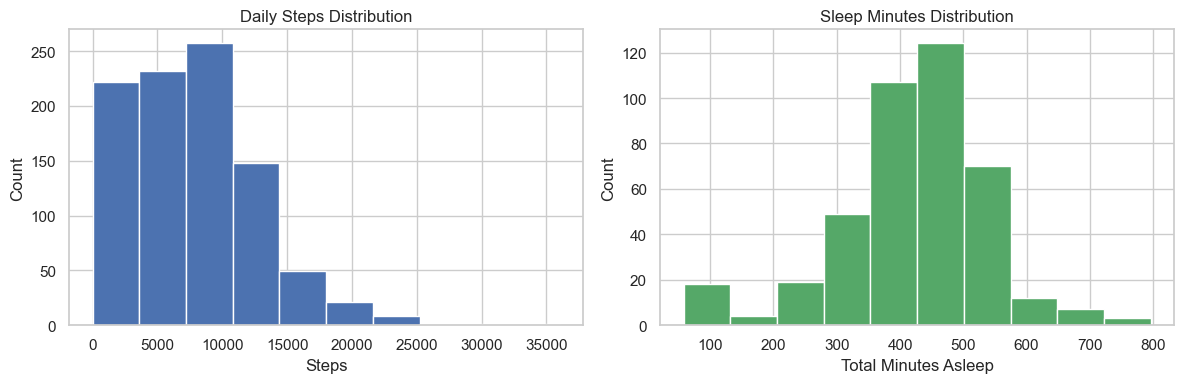

In [11]:
# 4. Visualizations on Raw Data
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(activity_df["TotalSteps"], bins=10, color="#4C72B0")
axes[0].set_title("Daily Steps Distribution")
axes[0].set_xlabel("Steps")
axes[0].set_ylabel("Count")

axes[1].hist(sleep_df["TotalMinutesAsleep"], bins=10, color="#55A868")
axes[1].set_title("Sleep Minutes Distribution")
axes[1].set_xlabel("Total Minutes Asleep")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()


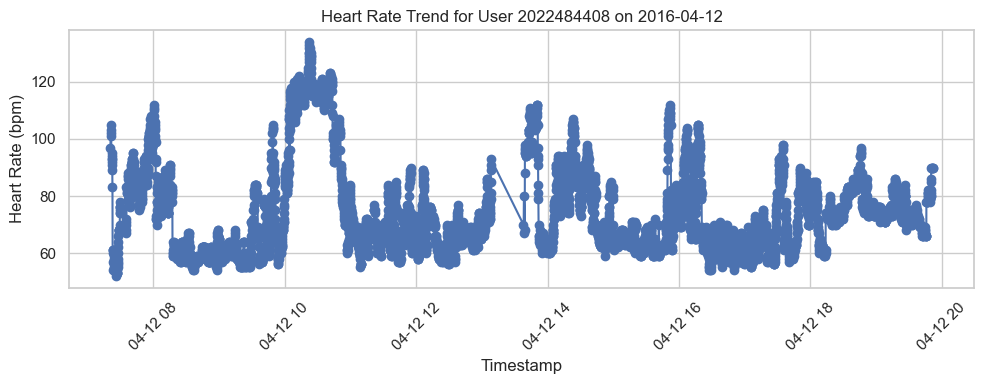

In [12]:
# Heart rate time series example
heartrate_df['Time'] = pd.to_datetime(heartrate_df['Time'])
sample_user = heartrate_df['Id'].iloc[0]
sample_date = heartrate_df['Time'].dt.date.iloc[0]

hr_sample = heartrate_df[(heartrate_df['Id'] == sample_user) & (heartrate_df['Time'].dt.date == sample_date)].copy()
hr_sample = hr_sample.sort_values('Time')

plt.figure(figsize=(10, 4))
plt.plot(hr_sample['Time'], hr_sample['Value'], marker='o', linestyle='-')
plt.title(f"Heart Rate Trend for User {sample_user} on {sample_date}")
plt.xlabel("Timestamp")
plt.ylabel("Heart Rate (bpm)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The selected user's heart rate pattern shows daytime peaks (around midday) with lower values during morning and evening, illustrating typical circadian variation and activity-driven heart rate changes.

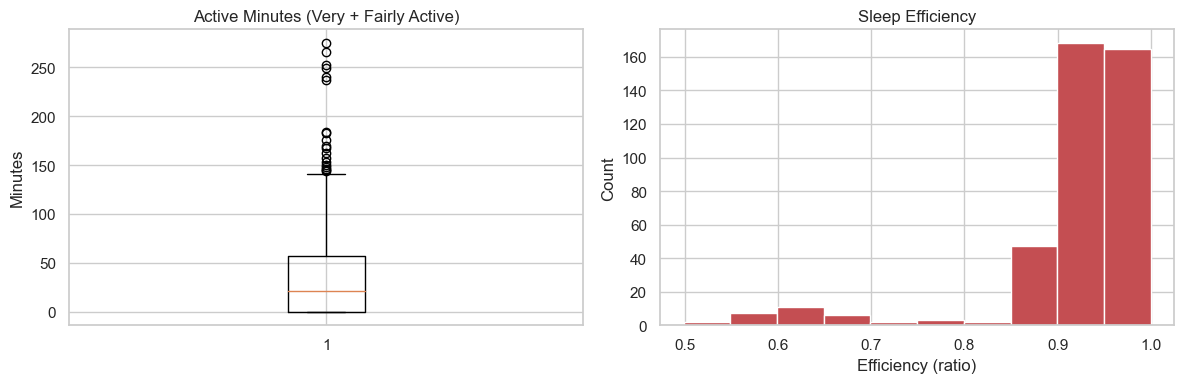

In [13]:
# 5. Feature Engineering Demonstration
activity_df = activity_df.copy()
sleep_df = sleep_df.copy()
activity_df['active_minutes'] = activity_df['VeryActiveMinutes'] + activity_df['FairlyActiveMinutes']
sleep_df['sleep_efficiency'] = sleep_df['TotalMinutesAsleep'] / sleep_df['TotalTimeInBed']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].boxplot(activity_df['active_minutes'].dropna())
axes[0].set_title('Active Minutes (Very + Fairly Active)')
axes[0].set_ylabel('Minutes')

axes[1].hist(sleep_df['sleep_efficiency'].dropna(), bins=10, color='#C44E52')
axes[1].set_title('Sleep Efficiency')
axes[1].set_xlabel('Efficiency (ratio)')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()


Higher active_minutes reflect more vigorous time across the day, while sleep_efficiency highlights how much time in bed results in actual sleep; both are useful precursors for risk profiling.

In [14]:
# 6. Load Processed Daily Metrics Dataset
processed_path = "data/processed/daily_metrics.csv"
metrics_df = pd.read_csv(processed_path, parse_dates=["date"])
metrics_df.head()

,id,date,total_steps,total_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,calories,total_minutes_asleep,total_time_in_bed,sleep_efficiency,avg_hr,max_hr,min_hr,active_minutes,source
0,1624580081,2016-05-09,1732,1.13,0,0,91,1349,1328,NaN,NaN,NaN,NaN,NaN,NaN,0,fitbit_bella_b
1,2320127002,2016-05-05,5202,3.51,0,11,223,1206,1780,NaN,NaN,NaN,NaN,NaN,NaN,11,fitbit_bella_b
2,4558609924,2016-04-15,7795,5.15,17,30,262,1131,2121,NaN,NaN,NaN,90.863490,146.0,58.0,47,fitbit_bella_b
3,6775888955,2016-05-01,2487,1.78,9,34,50,1347,2319,NaN,NaN,NaN,107.139171,129.0,70.0,43,fitbit_bella_b
4,7007744171,2016-05-02,13041,9.18,64,14,250,1112,2642,NaN,NaN,NaN,86.105711,147.0,58.0,78,fitbit_bella_b


In [15]:
metrics_info = metrics_df.info()
metrics_describe = metrics_df.describe()
metrics_info, metrics_describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      943 non-null    int64         
 1   date                    943 non-null    datetime64[ns]
 2   total_steps             943 non-null    int64         
 3   total_distance          943 non-null    float64       
 4   very_active_minutes     943 non-null    int64         
 5   fairly_active_minutes   943 non-null    int64         
 6   lightly_active_minutes  943 non-null    int64         
 7   sedentary_minutes       943 non-null    int64         
 8   calories                943 non-null    int64         
 9   total_minutes_asleep    413 non-null    float64       
 10  total_time_in_bed       413 non-null    float64       
 11  sleep_efficiency        413 non-null    float64       
 12  avg_hr                  335 non-null    float64   

(None,
                  id                           date   total_steps  \
 count  9.430000e+02                            943    943.000000   
 mean   4.858486e+09  2016-04-26 07:21:18.897136896   7652.188759   
 min    1.503960e+09            2016-04-12 00:00:00      0.000000   
 25%    2.320127e+09            2016-04-19 00:00:00   3795.000000   
 50%    4.445115e+09            2016-04-26 00:00:00   7439.000000   
 75%    6.962181e+09            2016-05-04 00:00:00  10734.000000   
 max    8.877689e+09            2016-05-12 00:00:00  36019.000000   
 std    2.423712e+09                            NaN   5086.532832   
 
        total_distance  very_active_minutes  fairly_active_minutes  \
 count      943.000000           943.000000             943.000000   
 mean         5.502853            21.239661              13.628844   
 min          0.000000             0.000000               0.000000   
 25%          2.620000             0.000000               0.000000   
 50%          5.2600

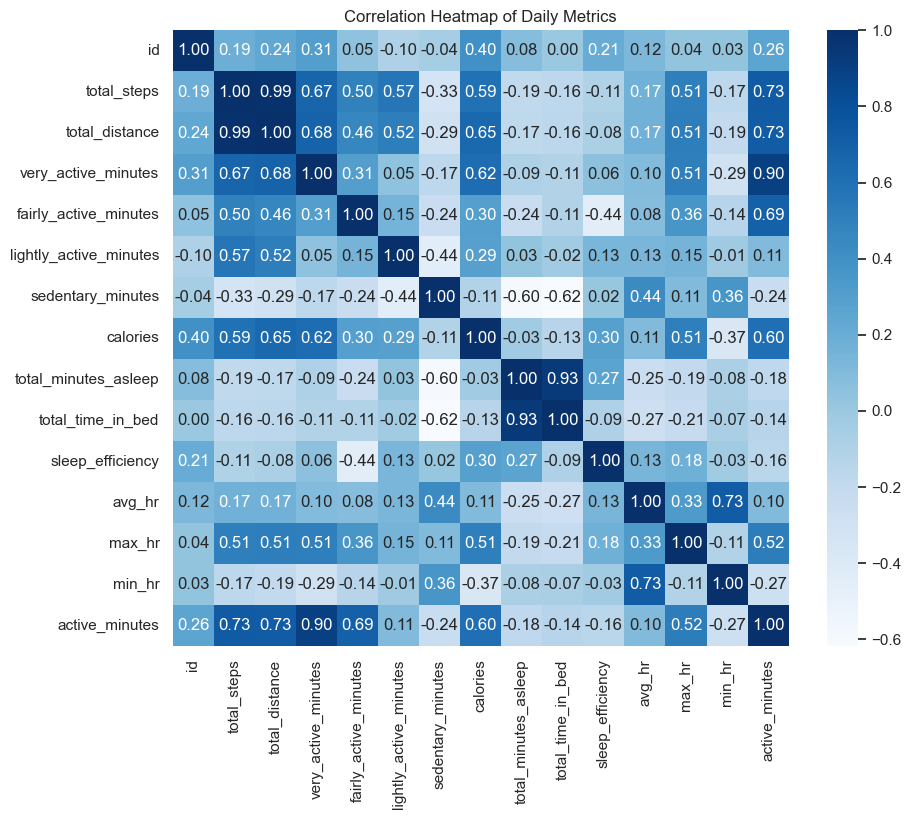

In [16]:
# 7. Correlation Heatmap
numeric_cols = metrics_df.select_dtypes(include=[np.number]).columns
corr = metrics_df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues", square=True)
plt.title("Correlation Heatmap of Daily Metrics")
plt.show()


In [17]:
# 8. Apply Risk Labeling (using project code)
from src.ml.risk_labeling import add_risk_labels

labeled_df = add_risk_labels(metrics_df)

label_columns = [
    "sleep_quality_risk",
    "cardiovascular_strain_risk",
    "stress_risk",
    "health_risk_level",
]

for col in label_columns:
    display(labeled_df[col].value_counts(dropna=False))


sleep_quality_risk
NaN         530
low         190
high        121
moderate    102
Name: count, dtype: int64

cardiovascular_strain_risk
NaN         608
moderate    221
low          67
high         47
Name: count, dtype: int64

stress_risk
moderate    761
low         182
Name: count, dtype: int64

health_risk_level
NaN         761
moderate    158
low          22
high          2
Name: count, dtype: int64

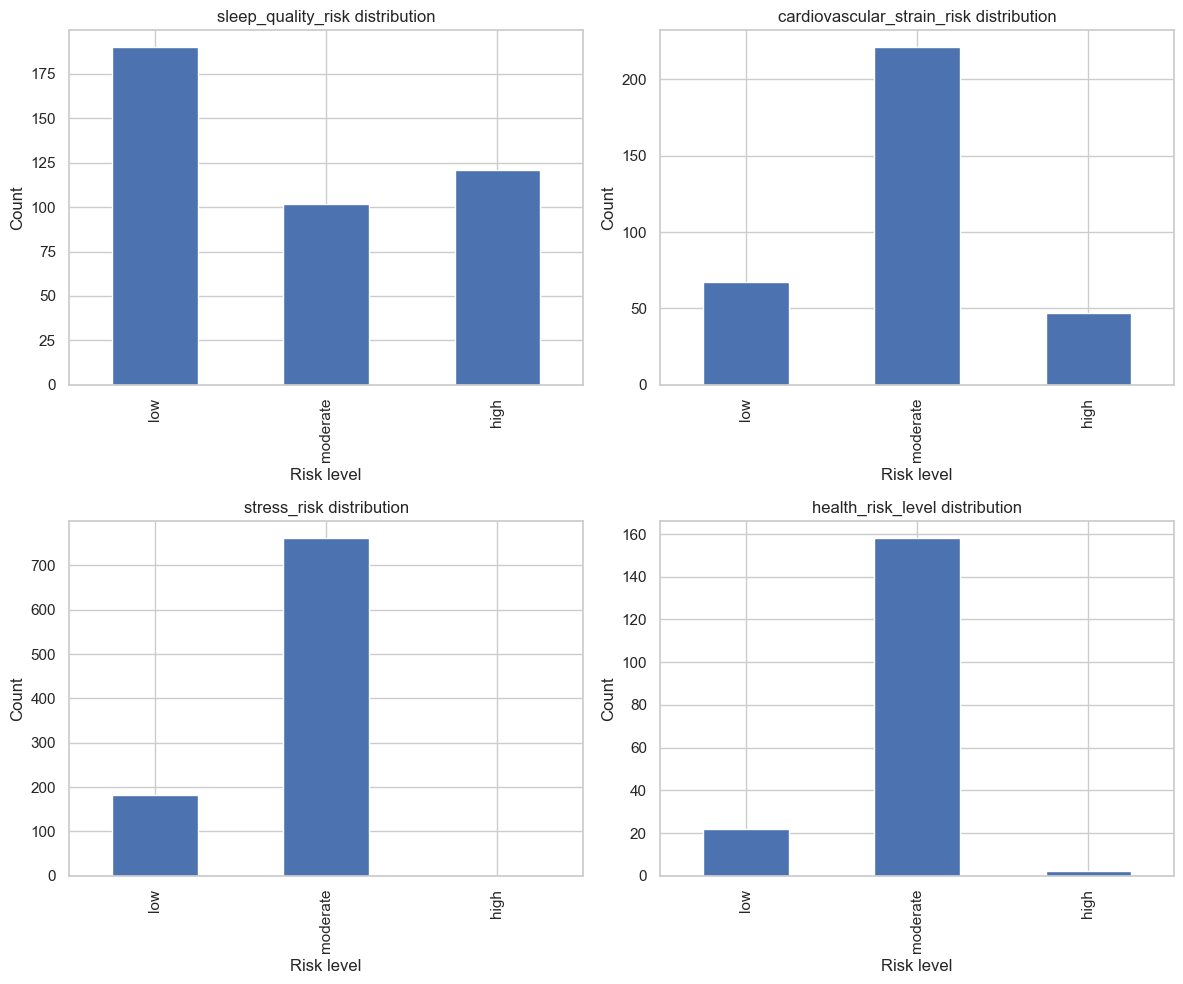

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
for ax, col in zip(axes, label_columns):
    labeled_df[col].value_counts().reindex(['low','moderate','high']).plot(kind='bar', ax=ax, color='#4C72B0')
    ax.set_title(f"{col} distribution")
    ax.set_ylabel('Count')
    ax.set_xlabel('Risk level')
plt.tight_layout()
plt.show()


Risk thresholds follow project conventions: balanced sleep duration (7–9 hours) and efficiency ≥85% map to **low** sleep risk; very short/long sleep or efficiency <75% yields **high**. Cardiovascular strain escalates with high average or peak heart rates combined with limited active time, while stress risk rises with elevated resting rates, low sleep, and long sedentary periods. The combined **health_risk_level** summarizes the trio, and in this sample most days fall into moderate ranges with occasional high or low days.

In [19]:
# 9. Mini In-Notebook Model Demo
feature_cols = [
    "total_steps",
    "total_distance",
    "very_active_minutes",
    "fairly_active_minutes",
    "lightly_active_minutes",
    "sedentary_minutes",
    "calories",
    "total_minutes_asleep",
    "sleep_efficiency",
    "avg_hr",
    "max_hr",
    "min_hr",
    "active_minutes",
]

model_df = labeled_df.dropna(subset=feature_cols + ["health_risk_level"]).copy()

X = model_df[feature_cols]
y = model_df["health_risk_level"]

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded if len(np.unique(y_encoded)) > 1 else None
)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

print(f"Accuracy: {accuracy:.2f}")
print(f"Macro F1: {f1:.2f}")


Accuracy: 0.92
Macro F1: 0.76


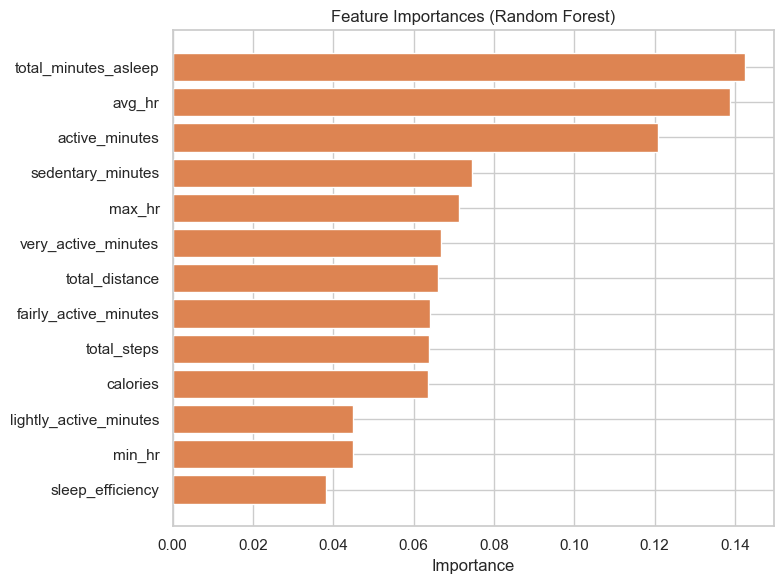

In [20]:
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices], color="#DD8452")
plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


The miniature model highlights which daily metrics drive the health_risk_level label—features tied to activity volume, sleep efficiency, and heart rate dynamics typically rank highest, underscoring their importance when interpreting daily wellness and informing the production-grade pipeline and Streamlit app visualizations.

## 10. Final Summary
- Fitbit activity, sleep, and heart-rate exports reveal daily behavior patterns such as step volume, time in various intensity zones, sleep duration, and circadian heart rate trends.
- Derived features like **active_minutes** and **sleep_efficiency** sharpen interpretation by combining key behaviors into single, risk-aware signals.
- Project risk labels translate these signals into actionable categories (sleep quality, cardiovascular strain, stress, overall health risk) and the example model shows how predictors map to outcomes.
- These analyses connect directly to the broader pipeline: the ETL job builds `daily_metrics.csv`, labeling enriches it for modeling, and the Streamlit app surfaces insights for users and stakeholders.